In [1]:
import datetime
import os

import numpy as np
import polars as pl

import joblib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.decomposition import PCA

from scipy.stats import rankdata


In [2]:
dt = datetime.datetime.now()
print(dt.strftime("%Y-%m-%d"))
print(dt.strftime("%H-%M-%S"))
print(dt.strftime("%Y-%m-%d/%H-%M-%S"))

2023-07-10
01-44-48
2023-07-10/01-44-48


In [3]:
def scatter_each_classes(
    data: np.ndarray, 
    class_labels: list[int], 
    rank: np.ndarray, 
    markers: list[str], 
    colors: list[str], 
    xylabel: tuple[str, str], 
    face_color: str='valid', 
    scatter_classes: tuple[int, ...] | None = None
) -> None:
    labels = np.unique(class_labels) if scatter_classes is None else scatter_classes
    markers = markers if markers is not None else ['o'] * np.unique(class_labels).shape[0]
    colors = [plt.get_cmap('tab10')(i) for i in range(len(labels))] if colors == 'tab10' else colors
    print(markers)
    
    if isinstance(colors, matplotlib.colors.LinearSegmentedColormap):
        for l, r in zip(labels, rank):
            if (face_color == 'None') and (markers[l] != 'x'):
                plt.scatter(data[class_labels==l, 0], data[class_labels==l, 1], edgecolors=colors(l / len(labels)), label=f'cluster{l}', marker=markers[l], face_color=face_color, zorder=r)
            else:
                plt.scatter(data[class_labels==l, 0], data[class_labels==l, 1], c=colors(l / len(labels)), label=f'cluster{l}', marker=markers[l], zorder=r)
    else:
        for l, r in zip(labels, rank):
            if (face_color == 'None') and (markers[l] != 'x'):
                plt.scatter(data[class_labels==l, 0], data[class_labels==l, 1], edgecolors=colors[l], label=f'cluster{l}', marker=markers[l], face_color=face_color, zorder=r)
            else:
                plt.scatter(data[class_labels==l, 0], data[class_labels==l, 1], c=colors[l], label=f'cluster{l}', marker=markers[l], zorder=r)

    plt.xlabel(xylabel[0])
    plt.ylabel(xylabel[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.tight_layout()
    plt.show()

In [4]:
def concat_images(imgs, n_col, n_row, padding):
    w, h = imgs[0].size
    w_with_pad = w + padding
    h_with_pad = h + padding
    W = (w_with_pad) * n_col + padding
    H = (h_with_pad) * n_row + padding

    dst = Image.new('L', (W, H))
    iter_imgs = iter(imgs)
    for j in range(n_row):
        for i in range(n_col):
            img = next(iter_imgs)
            dst.paste(img, (padding + w_with_pad * i, padding + h_with_pad * j))
    return dst

In [5]:
def make_path_from_df(row):
    return Path(f"{row['dirname']}/{row['filename']}")

In [6]:
def image_concat_and_imshow(df: pl.DataFrame, labels, colrow: tuple[int, int], image_root: str | Path) -> list[Image.Image]:
    concat_imgs = []
    num_labels = len(np.unique(labels))
    for l in np.unique(labels):
        imgs = []
        df_ = df[labels == l].sample(colrow[0] * colrow[1])
        df_.apply(make_path_from_df, axis=1)
        for p in df_.apply(make_path_from_df, axis=1):
            imgs.append(Image.open(image_root / p))
        concat_imgs.append(concat_images(imgs, colrow[0], colrow[1], 2))

    fig = plt.figure(figsize=(10,11))
    axes = list(map(lambda f: fig.add_subplot(1,num_labels,f+1), range(num_labels)))
    for i in range(num_labels):
        axes[i].imshow(concat_imgs[i], )
        axes[i].set_title(f'cluster {i}')
        axes[i].axis('off')

    plt.show()

    return concat_imgs

In [7]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markers = ['s', 'D', 'o', 'p', '*', 'h', 'D', '8', 'v', 'x']

model_save_pardir = Path("../models/")

# feature_csv_path = "/home/shinsei/MyResearchs/feat_extrc/reports/features/SimpleCAE32/2023-07-07/12-15-24/features.csv"
feature_train_csv_path = "/workdir/reports/features/train_data_features.csv"
feature_check_csv_path = "/workdir/reports/features/check_data_features.csv"

In [32]:
df_train = pl.read_csv(feature_train_csv_path)
X_train = df_train.select([
    pl.exclude(["filename", "dirname"])
]).to_numpy()
df_train.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,…,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,dirname,filename
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
-0.054948,-0.726282,-0.411437,0.689819,0.55469,-0.525348,-0.192606,0.507183,0.485844,-0.297544,0.338527,0.501919,0.272415,0.298217,0.26853,0.149128,-0.320242,0.368728,0.228594,-0.506494,0.480204,-0.500947,-0.994432,0.470796,0.727648,-0.496146,-0.123372,0.546982,-0.29012,-0.791117,0.404159,0.146871,0.896516,0.05958,0.32999,0.672341,-0.280316,…,0.422266,0.547537,0.406969,0.086191,0.286165,0.326351,-0.172407,0.631867,0.051106,-0.476555,-0.076156,0.035987,0.598799,-0.040389,0.164808,0.482882,0.264422,-0.550187,0.468537,0.151435,-0.934677,-0.863772,-0.112431,-0.717841,-0.788888,-0.128183,0.059202,-0.16385,-0.314812,-0.307213,-0.500076,0.820368,0.511424,-0.10142,0.686284,0,"""10k_0_h000_w00…"
0.152911,0.355963,-0.713065,0.347697,-0.80638,0.43935,-0.546498,0.295035,-0.316168,-0.548879,0.253562,0.576312,-0.245218,-0.313797,-0.067177,-0.070957,-0.593493,-0.044786,0.302908,-0.181241,-0.616899,-0.68743,-0.636856,0.17777,0.450658,-0.450902,-1.022391,-0.802609,-0.048698,-0.407747,0.232196,1.044976,0.029417,0.407215,0.485321,0.397472,0.65438,…,0.50651,0.210502,0.758659,-0.410589,0.138868,0.190713,-0.44125,0.514531,0.205793,-0.020739,-0.602514,0.296723,0.026805,-0.380035,0.22376,0.547029,0.159484,0.106013,-0.029241,0.190414,-0.606785,0.251512,0.013587,0.066875,-0.274932,-0.870289,0.479534,0.623892,-0.935171,-0.692457,0.095223,0.974208,-0.521238,0.729404,-0.414876,0,"""10k_0_h000_w00…"
0.003297,0.381085,-0.775776,0.116265,0.090428,-0.174479,-0.533924,0.125096,-0.275112,-0.401666,-0.722851,-0.645573,0.622601,-0.790461,-0.802538,-0.64329,0.513567,0.272448,-0.316215,-0.03304,-0.038906,0.054158,0.309461,-0.377935,0.202109,-0.765174,0.498631,-0.545303,0.396739,0.319783,-0.077586,0.661163,1.03738,-0.166837,0.332312,0.363785,0.135956,…,0.945189,0.575749,-0.033298,0.348081,0.212276,0.2285,0.743441,0.241927,0.0654,-0.591201,-0.389327,-0.026294,-0.233776,-0.637398,-0.527151,0.11987,-0.150096,0.992162,0.925361,0.220168,0.520416,1.571258,0.265999,-0.386061,-0.247226,0.465774,0.903046,0.386468,0.092105,0.472466,0.096821,0.67833,-0.095387,0.56968,-0.165714,0,"""10k_0_h000_w00…"
-0.679395,0.946653,-1.160618,0.044055,0.073188,0.084117,-0.110436,0.234357,1.070657,0.337187,0.190233,-0.961556,-0.152432,0.80312,0.720816,-0.929843,1.044046,-0.947788,1.242951,0.055133,0.700599,-0.238432,0.569992,-0.14046,0.82356,0.440809,0.156917,-0.647863,-0.539617,0.134088,0.068786,0.235018,0.507418,-0.612188,0.067743,0.357087,-0.676023,…,-0.785204,0.262026,0.572282,0.531918,-0.194371,1.057433,0.934983,-0.488589,0.717521,0.271843,0.833659,-0.069045,-0.52315,0.555888,-0.747919,0.245846,-0.405556,0.590465,0.919336,-0.306593,0.07645,-0.055232,-0.368224,0.7323,-0.352936,0.28948,-0.59702,0.777418,0.273391,0.687402,0.012525,-0.53303,1.686582,-0.01811,0.8305,0,"""10k_0_h000_w00…"
1.237273,0.12582,0.573737,-0.325089,-0.881777,-0.178526,1.433707,-0.097002,0.609527,0.967844,-0.527104,-0.815088,0.12873,0.089659,-0.434439,0.514092,-0.56607,0.663153,0.04081

In [9]:
df_check = pl.read_csv(feature_check_csv_path)
X_check = df_check.select([
    pl.exclude(["filename", "dirname"])
]).to_numpy()
df_check.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,…,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,dirname,filename
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
0.468788,-0.301893,0.030521,-0.288614,0.342371,0.074079,0.162194,-0.391805,0.379272,-0.431216,0.148311,0.030842,1.154272,-0.379679,0.163925,0.093842,-0.274287,0.160362,-0.619851,-0.146262,0.254824,0.259544,-0.487565,-0.820441,-0.147765,0.146334,0.577219,-0.371445,-0.524737,-0.033036,0.013138,0.169165,0.339046,-0.02493,-0.051948,0.286481,0.505793,…,-0.47368,-0.309295,0.214219,-0.017099,0.22861,0.221589,-0.16278,0.295244,-0.138153,0.011499,-0.254573,0.572798,0.21744,-0.663398,-0.608381,-0.447647,0.202552,0.068512,-0.504603,-0.318019,0.15804,-0.083406,-0.531587,0.491395,0.856411,-0.524653,-0.411159,0.362434,0.316975,-0.570047,0.2849,0.187027,0.701761,-0.384929,-0.116087,0,"""10k_0_h000_w00…"
0.342763,0.043147,-0.448079,-0.208444,0.213164,0.454861,0.041915,-1.128912,0.042992,0.700914,-0.221912,-0.406664,0.631386,0.091957,-0.430564,-0.661089,-0.42815,0.136162,0.34664,0.305173,-0.158113,0.574676,0.298539,0.155176,0.38781,0.903792,-0.079442,0.640554,0.24976,0.815875,0.683621,0.52508,-0.164614,9.6943e-7,-0.051329,0.435619,0.139083,…,0.174802,-0.242281,0.245031,-0.230087,0.598701,0.204987,-0.926791,0.164733,-0.070374,0.342854,0.100408,-0.068473,-0.725832,0.562028,-0.525089,-0.539848,-0.624442,0.582947,-0.315103,-0.011187,-0.630243,0.485856,-0.542667,-0.045301,0.346324,0.791502,-0.046272,0.65798,-0.101714,-0.353928,-0.564125,0.527792,0.129799,0.534237,-0.537469,0,"""10k_0_h000_w00…"
0.191901,-0.6356,0.308396,0.089327,-0.623309,0.130831,-0.118396,0.260426,0.611111,0.372199,-0.627916,-0.197619,0.327874,-0.68929,0.468568,0.31611,-0.476624,0.645113,-0.651507,-0.125913,-0.419708,0.019023,0.390637,-0.066754,-0.087088,0.010399,-0.390894,0.067128,-0.338966,-0.52132,1.629353,-0.159863,0.01632,0.359623,-0.266165,0.814102,0.183704,…,0.873599,0.585534,-0.353881,0.362732,0.090362,0.024336,-0.303939,0.580424,-0.290945,-0.001322,-0.637768,-0.10088,0.301205,-0.176331,0.386784,-0.588078,-0.069722,0.310595,0.264303,-0.714235,-0.320415,-0.120307,0.353979,0.074147,-0.261427,-0.388679,-0.324116,-0.859055,-0.719669,-0.164883,-0.291009,0.330204,0.839018,0.709156,-0.044775,0,"""10k_0_h000_w00…"
-0.197477,-0.388805,0.078355,0.067745,0.515734,0.280737,-0.867723,-0.383065,0.700564,-0.274088,0.562182,-0.151231,-0.858039,-0.276846,0.089235,-0.265483,0.435065,-1.054066,0.280303,0.29575,0.201453,0.078687,0.725454,0.04613,0.407864,-0.825255,0.440761,0.445398,0.352459,-0.590818,-0.203541,0.256023,0.147306,0.42261,-0.348691,-0.013422,0.157959,…,-0.971141,0.511914,-0.692593,0.085239,0.628712,1.006747,-0.880745,0.549287,-0.383837,-0.392037,0.064346,0.151817,-0.624008,0.281051,0.628405,0.192242,-0.359567,-0.184111,0.740115,0.001087,0.294496,-0.341474,-0.074378,-0.391373,0.212198,-0.478604,0.2426,0.03883,-0.392387,-0.174945,-0.442421,-0.096345,-0.28343,-0.129294,0.378909,0,"""10k_0_h000_w00…"
0.252246,0.702785,0.462661,0.251017,-0.136466,-0.042101,0.20263,0.096175,-0.768835,0.04665,1.376439,-0.805701,0.282384,0.546047,-0.502469,0.061514,0.

In [10]:
sc = StandardScaler()
pca = PCA()

X_train_std = sc.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_std)

X_check_std = sc.transform(X_check)
X_check_pca = pca.transform(X_check_std)

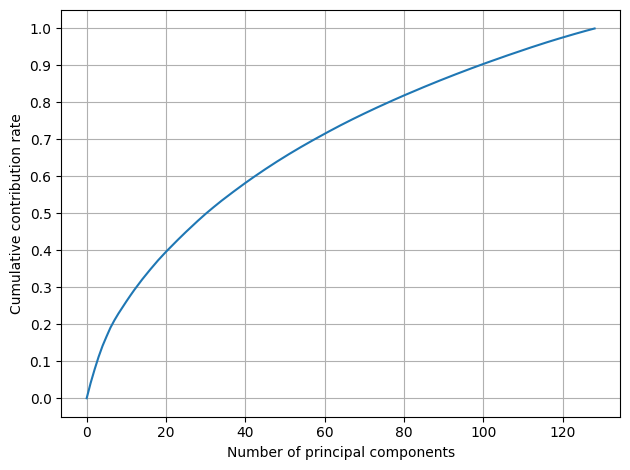

In [11]:
cumsum_contrb_rate = pca.explained_variance_ratio_.cumsum()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(X_train.shape[1]+1), [0]+list(cumsum_contrb_rate))
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Cumulative contribution rate')
ax.set_yticks(np.arange(0., 1.1, 0.1))
ax.grid()
fig.tight_layout()
plt.show()

In [12]:
num_use_features = cumsum_contrb_rate[cumsum_contrb_rate < 0.5].shape[0]

In [13]:
cluster_elements: list[int] = [3, 6, 10, 8, 9, 7, 1]
predicted_cluster = np.random.randint(0, len(cluster_elements), 4)
rank = rankdata(cluster_elements, method="ordinal") - 1
print(predicted_cluster)
print(rank)
print(rank[predicted_cluster])

[3 6 3 2]
[1 2 6 4 5 3 0]
[4 0 4 6]


vbgmm_pca_30_10clusters


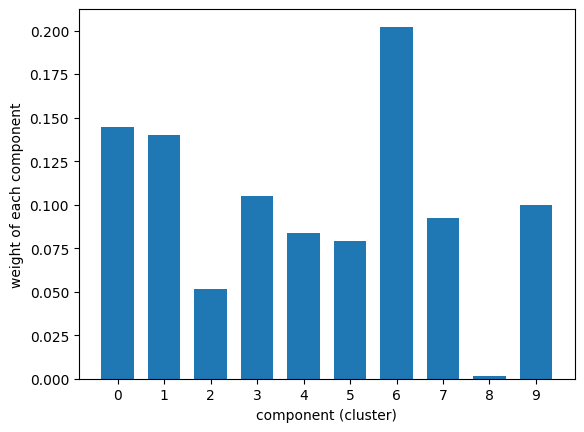

In [51]:
dt = datetime.datetime.now()
nc = 10

clustering_type = f'vbgmm_pca_{num_use_features}_{nc}clusters'
print(clustering_type)

# vbgmm_train_pca = BayesianGaussianMixture(
#     n_components=nc,
#     max_iter=500,
#     n_init=10,
#     init_params="k-means++"
# )
# y_train_pca = vbgmm_train_pca.fit_predict(X_train_pca[:,:num_use_features])
vbgmm_train_pca: BayesianGaussianMixture = joblib.load("/workdir/notebooks/vbgmm_train_pca.pkl")
y_train_pca = vbgmm_train_pca.predict(X_train_pca[:,:num_use_features])
model_save_dir = model_save_pardir / dt.strftime("%Y-%m-%d/%H-%M-%S")
# if not model_save_pardir.exists():
#     os.makedirs(model_save_dir)
# joblib.dump(vbgmm_train_pca, model_save_dir / "vbgmm_train_pca.pkl")

rank_of_cluster_train_pca = rankdata(np.histogram(y_train_pca)[0], method='ordinal')
y_train_pca_sorted_cluster = rank_of_cluster_train_pca[y_train_pca]


# plt.subplot(4, 1, 4)
x_tick = np.arange(0, nc)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(x_tick, vbgmm_train_pca.weights_, width=0.7, tick_label=x_tick)
plt.xlabel('component (cluster)')
plt.ylabel('weight of each component')
plt.show()

In [52]:
df_cluster = pl.DataFrame({"cluster": y_train_pca_sorted_cluster})
df_train_vbgmm_10 = df_train.with_columns(df_cluster)

vbgmm_pca_30_100clusters


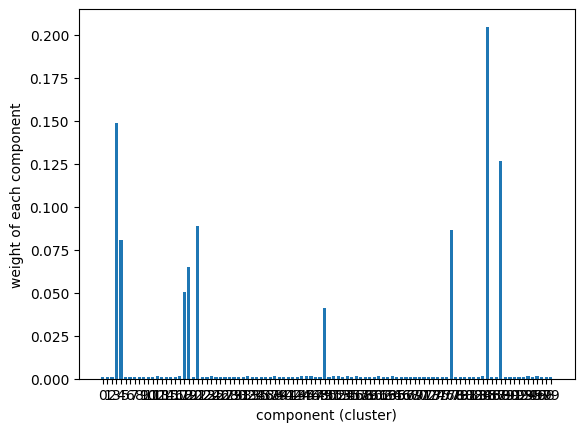

In [13]:
dt = datetime.datetime.now()

nc = 100

clustering_type = f'vbgmm_pca_{num_use_features}_{nc}clusters'
print(clustering_type)

vbgmm_train_pca_100 = BayesianGaussianMixture(
    n_components=nc,
    max_iter=500,
    n_init=10,
    init_params="k-means++"
)
y_train_pca = vbgmm_train_pca_100.fit_predict(X_train_pca[:,:num_use_features])

model_save_dir = model_save_pardir / dt.strftime("%Y-%m-%d/%H-%M-%S")
if not model_save_pardir.exists():
    os.makedirs(model_save_dir)
joblib.dump(model_save_dir / "vbgmm_train_pca_100.pkl")

rank_of_cluster_train_pca = rankdata(- vbgmm_train_pca_100.weights_, method='ordinal')
y_train_pca_sorted_cluster = rankdata[y_train_pca]

# plt.subplot(4, 1, 4)
x_tick = np.arange(0, nc)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(x_tick, vbgmm_train_pca_100.weights_, width=0.7, tick_label=x_tick)
plt.xlabel('component (cluster)')
plt.ylabel('weight of each component')
plt.show()

In [14]:
!pwd

/workdir/notebooks


In [15]:
joblib.dump(vbgmm_train_pca, "vbgmm_train_pca.pkl")
joblib.dump(vbgmm_train_pca_100, "vbgmm_train_pca_100.pkl")

['vbgmm_train_pca_100.pkl']

In [2]:
vbgmm: BayesianGaussianMixture = joblib.load("/workdir/notebooks/vbgmm_train_pca_100.pkl")

In [30]:
r = np.argsort(vbgmm_train_pca_100.weights_)
br = np.argsort(r)

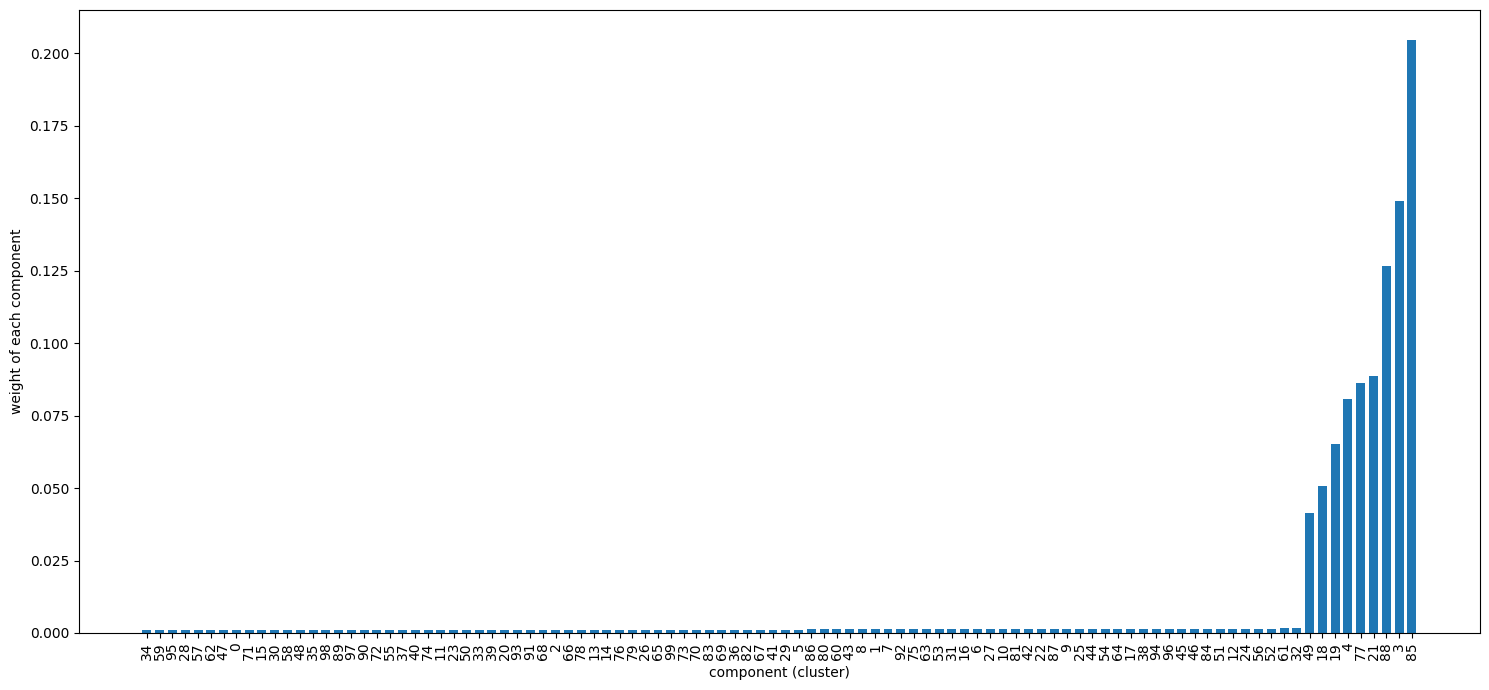

In [42]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
ax.bar(x_tick, vbgmm_train_pca_100.weights_[r], width=0.7, tick_label=x_tick)
ax.set_xlabel('component (cluster)')
ax.set_xticks(x_tick)
ax.set_xticklabels(r, rotation=90)
ax.set_ylabel('weight of each component')
fig.tight_layout()
plt.show()

In [ ]:
df_cluster = pl.DataFrame({"cluster": y_train_pca_sorted_cluster})
df_train.with_columns(df_cluster)